In [1]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
% matplotlib inline

In [2]:
# 导入数据集
train = pd.read_csv('train.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)
store = pd.read_csv('store.csv')

In [3]:
# 查看DataFrame
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
# 补全缺失值
test.fillna(1, inplace=True)
store.fillna(0, inplace=True)

In [6]:
# 合并数据集
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [7]:
# 查看数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 non-nu

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null object
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
dtypes: float64(6), int6

### 数据清理及格式转换
由于test.csv中没有Customers列，意味着最终模型预测时不依赖Customers列，因此将其删除，避免对模型产生影响  

Date列为str格式，机器无法理解，需要手动转化为datetime格式  

In [9]:
# 删除Customers列
train.drop(['Customers'], axis=1, inplace=True)

# 转换'Date'列为datetime格式
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

In [10]:
# 查看test.csv中StateHoliday的取值
test['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

由于test.csv中StateHoliday的取值只有0和a，经独热编码后，在后续对test.csv进行预测时会出现mismatch的情况导致无法预测，后续需对test.csv进行添加列处理

### 异常值处理
可能出现的异常情况有：商店开门，但销售额为0及商店未开门却有销售额

In [11]:
# 第一种情况：商店开门，但销售额为0
train[(train['Open'] == 1) & (train['Sales'] == 0)].shape[0]

54

In [12]:
# 第二种情况：商店未开门却有销售额
train[(train['Open'] == 0) & (train['Sales'] > 0)].shape[0]

0

In [13]:
train.shape[0] - 54

1017155

可以看到第一种情况存在，但去除异常数据后剩余数据有1017155条，对数据集大小影响很小

In [14]:
# 去除异常值
train = train.loc[((train['Open'] == 1) & (train['Sales'] > 0))]
train.drop(['Open'], axis=1, inplace=True)
test.drop(['Open'], axis=1, inplace=True)

### 数据可视化

直观上来说，可能影响销售额的因素有:
1. DayOfWeek: 如果商店不进行休息，那么周末的销售额可能会比工作日的销售额多，人们有更多的时间去商店
2. Date: 特定的时间可能受节日促销等的影响，销售额提升
3. Promo: 进行促销的日子应当能推动顾客的购买商品，从而提高销售额
4. CompetitonDistance: 附近有竞争对手，可能销售额会有所影响

In [15]:
#筛选1023号商店进行分析
sample1 = train[train['Store'] == 1023]

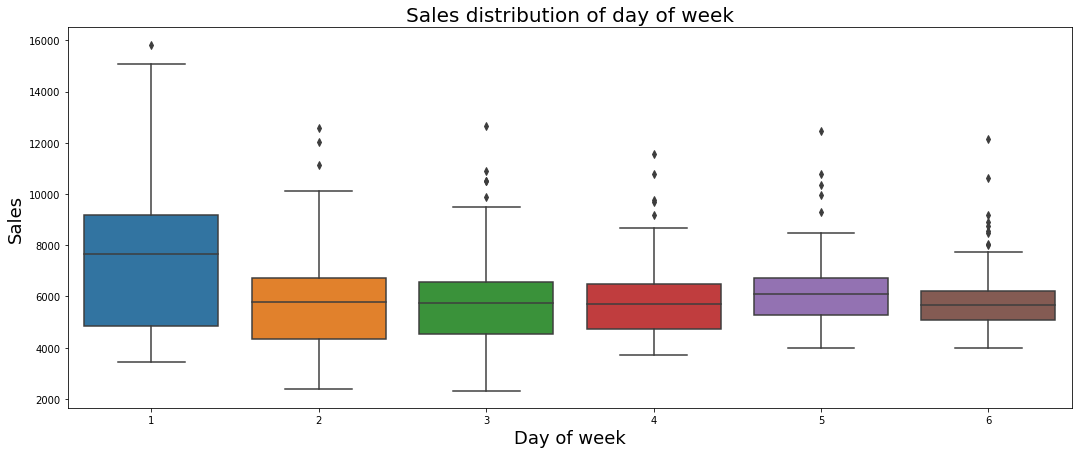

In [16]:
# Sales列对DayOfWeek列作图
plt.figure(figsize=(18,7))
sns.boxplot(x=sample1['DayOfWeek'], y=sample1['Sales']);
plt.title('Sales distribution of day of week', size=20);
plt.xlabel('Day of week', size=18);
plt.ylabel('Sales', size=18);
#plt.savefig('DayOfWeek.png')

可以看到，除了星期日商家休息无销售额外，星期一销售额分布比较分散，其中位数比其余日子大，为7500左右，而其余日子对销售额没有太大影响，中位数都落在6000左右

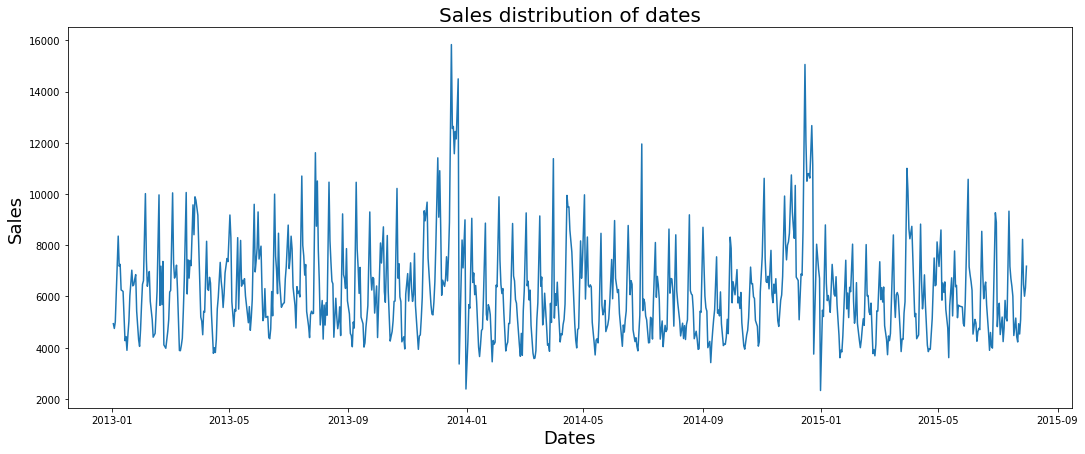

In [17]:
# Sales列对Date列作图
plt.figure(figsize=(18,7))
plt.plot(sample1['Date'], sample1['Sales']);
plt.title('Sales distribution of dates', size=20);
plt.xlabel('Dates', size=18);
plt.ylabel('Sales', size=18);
#plt.savefig('Dates.png')

可以看到，有趣的是，2014年和2015年的1月份左右有几天销售额是明显比其他日子高的，可能是由于新年假期的缘故。

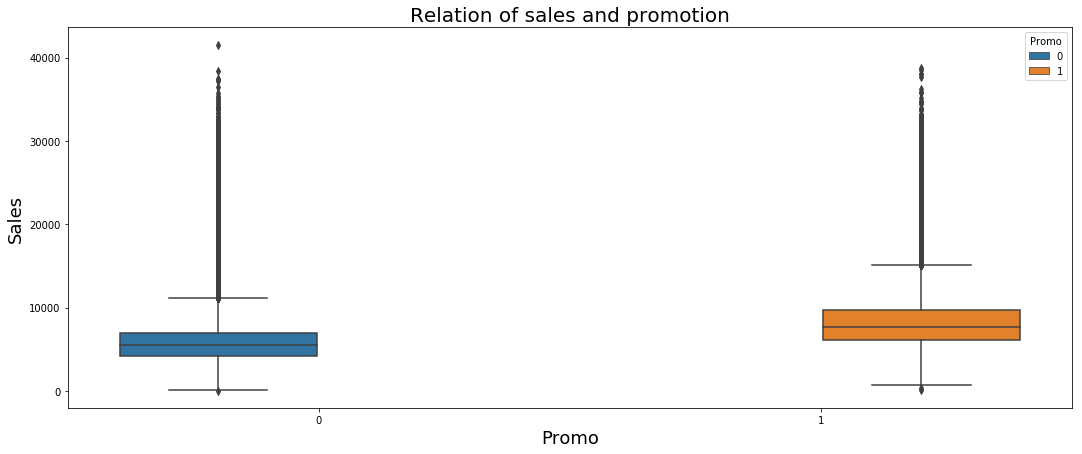

In [18]:
# 选取营业的商店进行分析
# Sales列对Promo列作图
plt.figure(figsize=(18,7))
sns.boxplot(x='Promo', y='Sales', hue='Promo', data=train);
plt.title('Relation of sales and promotion', size=20);
plt.xlabel('Promo', size=18);
plt.ylabel('Sales', size=18);
#plt.savefig('Promo.png')

可以看到，有促销的商店销售额的中位数比没有促销的商店高一点。由于已经剔除了商店不营业，销售额为0的情况，中位数不会受极小值影响。

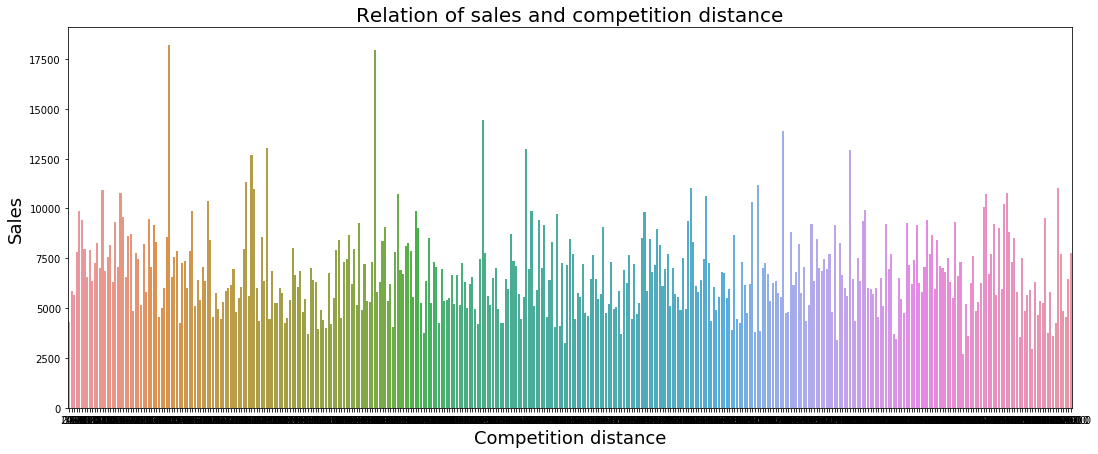

In [19]:
# 选取a类商店进行分析，对CompetitionDistance列进行groupby分组并取均值，以Sales列对处理后数据作图
store_a = train[train['StoreType'] == 'a']
distance_example = store_a.groupby(['CompetitionDistance'])['Sales'].mean()
plot_data = distance_example.reset_index()

plt.figure(figsize=(18,7))
sns.barplot(x='CompetitionDistance', y='Sales', data=plot_data);
plt.title('Relation of sales and competition distance', size=20);
plt.xlabel('Competition distance', size=18);
plt.ylabel('Sales', size=18);
#plt.savefig('CompetitionDistance.png')

可以看到，似乎竞争对手距离对销售额的影响并不明显

### 特征工程

 **将Date列拆分成day, month, year三个列以便模型理解，并删除Dates列**

In [20]:
# 对日期进行排序
train = train.sort_values(by='Date')

# 提取日期信息
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train['WeekOfYear'] = train['Date'].dt.weekofyear

test['Day'] = test['Date'].dt.day
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['WeekOfYear'] = test['Date'].dt.weekofyear

In [21]:
# 参考Kernel Rossmann Sales Top 1%: https://www.kaggle.com/xwxw2929/rossmann-sales-top1/notebook
def create_features(data):
    data['CompetitionOpen'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) + (data['Month'] - data['CompetitionOpenSinceMonth'])
    data['PromoOpen'] = 12 * (data['Year'] - data['Promo2SinceYear']) + (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data['Month'].map(month2str)
    data.loc[data['PromoInterval'] == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data['PromoInterval'].unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
  
    return data

train = create_features(train)
test = create_features(test)

In [22]:
# 对销售额进行log1p变换，使销售额接近正态分布
train['Sales'] = train['Sales'].apply(lambda x: np.log1p(x))

**独热编码(One-hot encoding)**   
StateHoliday, StoreType, Assortment和PromoInterval这几列属于无序的定类数据，各类别之间没有关联，如果直接进行标签编码(Label Encoding)，模型可能会误以为这些类别之间是有大小关系的，预测准确率可能会降低。这一问题可以利用独热编码解决。当然，独热编码也有缺点：数据的维度大大增加了。

In [23]:
train = pd.get_dummies(data=train,
                       columns=['StateHoliday','StoreType','Assortment'],
                       prefix=['StateHoliday','Store','Assort'])

test = pd.get_dummies(data=test,
                      columns=['StateHoliday','StoreType','Assortment'],
                      prefix=['StateHoliday','Store','Assort'])

## XGBoost 模型

### 参数优化

In [24]:
# 定义RMSPE
def rmspe(y, y_hat):
    return np.sqrt(np.mean((y_hat/y-1) ** 2))

def rmspe_xg(y_hat, y):
    y = np.expm1(y.get_label())
    y_hat = np.expm1(y_hat)
    return "rmspe", rmspe(y,y_hat)

In [25]:
train.iloc[-1]

Store                                          1
DayOfWeek                                      5
Date                         2015-07-31 00:00:00
Sales                                    8.56865
Promo                                          1
SchoolHoliday                                  1
CompetitionDistance                         1270
CompetitionOpenSinceMonth                      9
CompetitionOpenSinceYear                    2008
Promo2                                         0
Promo2SinceWeek                                0
Promo2SinceYear                                0
PromoInterval                                   
Day                                           31
Month                                          7
Year                                        2015
WeekOfYear                                    31
CompetitionOpen                               82
PromoOpen                                24187.8
monthStr                                     Jul
IsPromoMonth        

对日期进行排序后，发现最后日期为2015-07-31，六周前日期即为2015-06-19

In [26]:
# 切割训练集和验证集
# 取最后6周数据作为验证集
val_set = train[train['Date'] >= '2015-06-19']
train_set = train[train['Date'] < '2015-06-19']

y_train = train_set['Sales']
y_val = val_set['Sales']

# 舍弃无用列
X_train = train_set.drop(['Date', 'Sales', 'PromoInterval', 'monthStr'], axis=1)
X_val = val_set.drop(['Date', 'Sales', 'PromoInterval', 'monthStr'], axis=1)
test.drop(['Date', 'PromoInterval', 'monthStr'], axis=1, inplace=True)

In [27]:
# 创建RandomizedSearchCV的scorer
scorer = make_scorer(rmspe)

### 随机搜索

In [0]:
# 随机搜索参数设置
param = {
        'max_depth': [10],
        'subsample': [0.9],
        'eta': [0.01],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
        'gamma': [1.0, 2.0, 3.0, 4.0, 5.0],
        'lambda': [1.0, 2.0, 3.0, 4.0, 5.0]
        }

In [0]:
# 创建XGBoost回归模型
model = xgb.XGBRegressor(silent=1, objective='reg:linear', booster='gbtree', \
                         tree_method='gpu_hist', num_round=200, seed=0)

# 第一次随机搜索
randomized_search = RandomizedSearchCV(model, param, n_iter=30, scoring=scorer, \
                                       random_state=0)

In [22]:
# 输入训练集进行随机搜索
randomized_search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=1, subsample=1, tree_method='gpu_hist'),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'max_depth': [10], 'subsample': [0.9], 'eta': [0.01], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [0.5, 1.0, 2.0, 3.0, 4.0, 5.0], 'gamma': [1.0, 2.0, 3.0, 4.0, 5.0], 'lambda': [1.0, 2.0, 3.0, 4.0, 5.0]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=make_scorer(rmspe), verbose=0)

In [23]:
# 查看最优参数
randomized_search.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.01,
 'gamma': 2.0,
 'lambda': 1.0,
 'max_depth': 10,
 'min_child_weight': 1.0,
 'subsample': 0.9}

### 训练模型

In [28]:
# 转化为DMatrix
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

# 设置watchlist
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [29]:
# 将参数设为随机搜索后的最优值
params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'max_depth': 10,
        'eta': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.5,
        'min_child_weight': 1.0,
        'gamma': 2.0,
        'lambda': 1.0,
        'tree_method': 'gpu_hist',
        'silent': 1
        }

In [26]:
# 设置迭代次数
num_boost_round = 10000

import time
start = time.time()

# 训练XGBoost模型
xgb_model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

end = time.time()
xg_runtime = end - start

[0]	train-rmse:8.18566	eval-rmse:8.19572	train-rmspe:0.999864	eval-rmspe:0.999866
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10399	eval-rmse:8.11389	train-rmspe:0.999837	eval-rmspe:0.99984
[2]	train-rmse:8.02312	eval-rmse:8.03319	train-rmspe:0.99981	eval-rmspe:0.999812
[3]	train-rmse:7.94306	eval-rmse:7.95323	train-rmspe:0.999779	eval-rmspe:0.999783
[4]	train-rmse:7.86379	eval-rmse:7.8741	train-rmspe:0.999747	eval-rmspe:0.999751
[5]	train-rmse:7.78534	eval-rmse:7.79551	train-rmspe:0.999712	eval-rmspe:0.999717
[6]	train-rmse:7.70765	eval-rmse:7.71792	train-rmspe:0.999676	eval-rmspe:0.999681
[7]	train-rmse:7.63073	eval-rmse:7.64106	train-rmspe:0.999636	eval-rmspe:0.999642
[8]	train-rmse:7.55459	eval-rmse:7.56501	train-rmspe:0.999594	eval-rmspe:0.999601
[9]	train-rmse:7.47924	eval-rmse:7.48958	train-rmspe:0.999549	eval-rmspe:0.999556
[10]	train-rmse:7.40463	eval-rmse:7.4

In [0]:
# 保存模型
xgb_model.save_model('second_10000.model')

In [30]:
xgb_model = xgb.Booster(model_file='second_10000.model')

[22:27:02] src/learner.cc:377: Parameter 'predictor' will be set to 'cpu_predictor' since XGBoots wasn't compiled with GPU support.


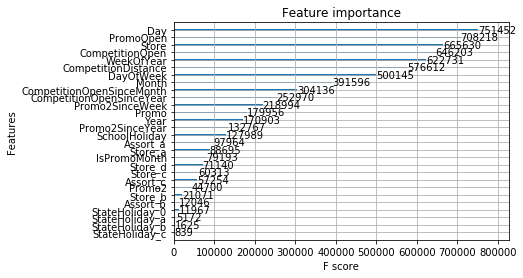

In [52]:
# 绘制特征重要性图
xgb.plot_importance(xgb_model)
plt.savefig('feature_importance.png')

In [31]:
# 用验证集对模型进行评分
y_pred = xgb_model.predict(xgb.DMatrix(X_val))
error = rmspe(y_val, y_pred)
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.0135


In [0]:
# 权重调整，参考Kernel Rossmann Sales Top 1%: https://www.kaggle.com/xwxw2929/rossmann-sales-top1/notebook
def weight_correction():
    weights = [(0.990+(i/1000)) for i in range(20)]
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_val), np.expm1(y_pred*w))
        errors.append(error)
    # plotting
    plt.plot(weights, errors)
    # print minimum error
    best_weight = weights[errors.index(min(errors))]
    print('Best weight is {}.'.format(best_weight))

Best weight is 0.996.


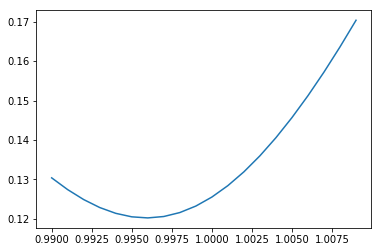

In [43]:
weight_correction()

In [0]:
# 将ID列单独取出并删除测试集里的ID
test_id = test['Id']
test.drop(['Id'], axis=1, inplace=True)

In [0]:
# 添加两列新列，防止mismatch的发生导致无法预测
test.insert(19, 'StateHoliday_b', 0)
test.insert(20, 'StateHoliday_c', 0)

In [0]:
# 对测试集进行预测
test_pred = xgb_model.predict(xgb.DMatrix(test))

In [0]:
# 将ID列放回提交的文件，预测数据乘以权重后进行变换
submit_file = pd.concat([test_id, pd.Series(np.expm1(test_pred*0.996))], axis=1)
# 重命名列
submit_file.rename(columns={0:'Sales'}, inplace = True)

In [0]:
# 保存为csv文件提交至Kaggle
submit_file.to_csv('second_subbmission_10000.csv', index=False)

## 基准模型(LightGBM)

In [0]:
# 转化训练集
lgb_train = lgb.Dataset(X_train, y_train)

In [0]:
# 设置为与XGBoost模型相同的参数
benchmark_params = {
        'max_depth': 10,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.5,
        'min_child_weight': 1.0,
        'gamma': 2.0,
        'lambda': 1.0,
        }

In [0]:
# 训练LightGBM模型
benchmark = lgb.train(benchmark_params, lgb_train, num_boost_round=10000, \
                      feval=rmspe_xg)

In [55]:
# 用验证集对模型进行评分
benchmark_pred = benchmark.predict(X_val)
benchmark_error = rmspe(y_val, benchmark_pred)
print('RMSPE: {:.4f}'.format(benchmark_error))

RMSPE: 0.0157


In [0]:
# 用基准模型对测试集进行预测
benchmark_test_pred = benchmark.predict(test)

In [0]:
# 将ID列放回提交的文件
benchmark_submit_file = pd.concat([test_id, pd.Series(np.expm1(benchmark_test_pred*0.996))], axis=1)
# 重命名列
benchmark_submit_file.rename(columns={0:'Sales'}, inplace = True)

In [0]:
# 保存为csv文件提交至Kaggle
benchmark_submit_file.to_csv('benchmark_second_submission.csv', index=False)

## 结果可视化

In [32]:
# 创建包含验证集真实值和预测值的DataFrame
res = pd.DataFrame(data = y_val)
res['Prediction'] = y_pred
res = pd.merge(X_val, res, left_index= True, right_index=True)
res = res.sort_values(by=["Year", "Month", "Day"], ascending=[True, True, True])

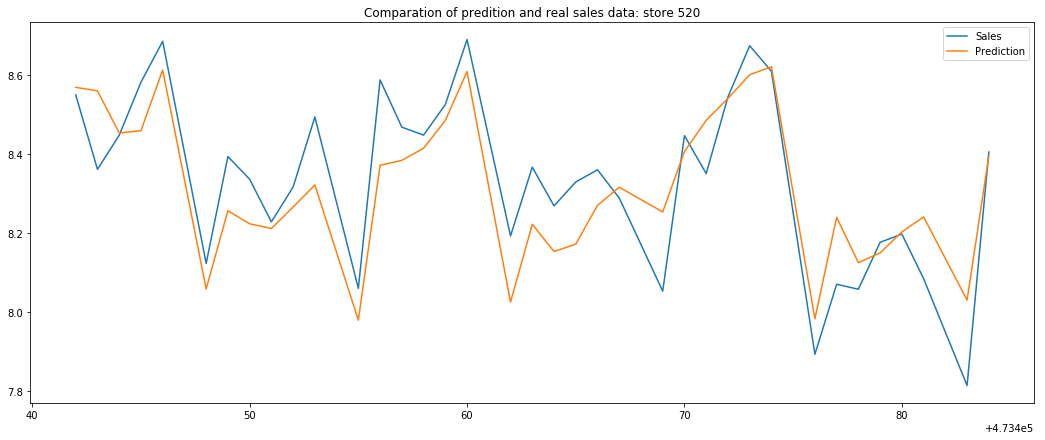

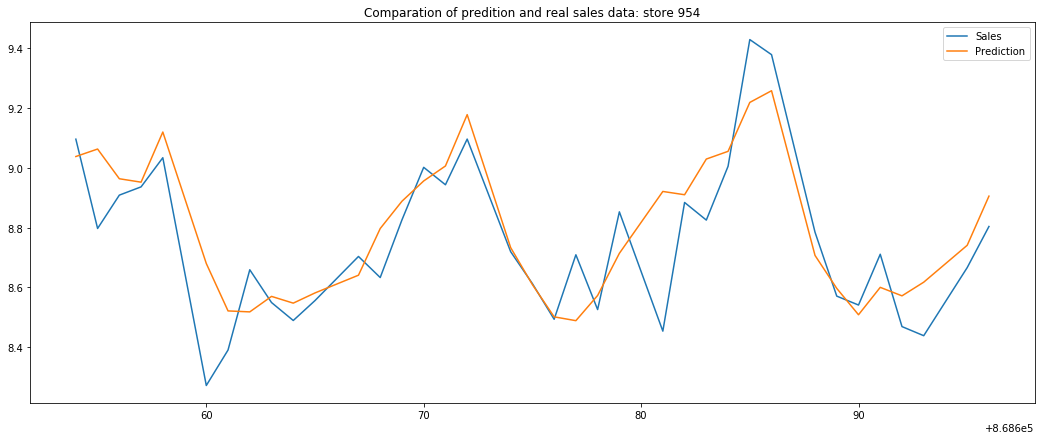

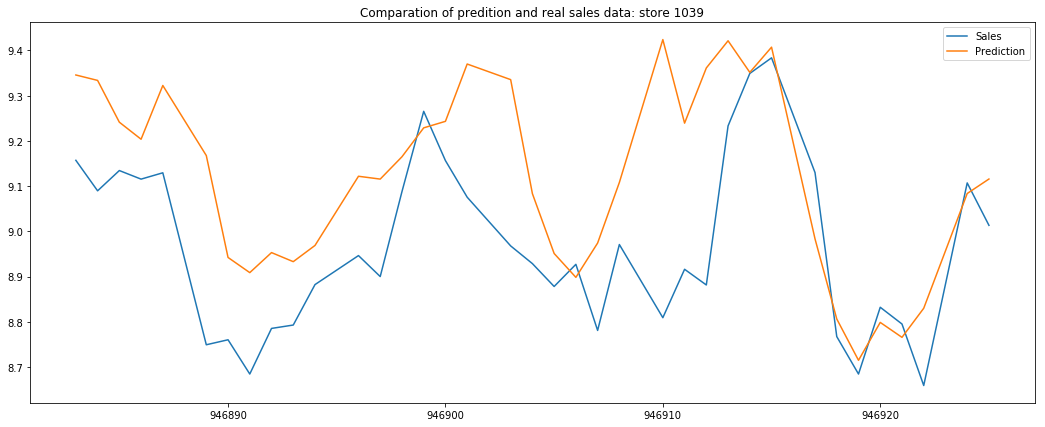

In [33]:
col_1 = ['Sales', 'Prediction']
# 随机抽取商店
L = np.random.randint(low=1, high=1115, size=3)

# 可视化
for i in L:
    s1 = pd.DataFrame(res[res['Store'] == i], columns = col_1)
    s1.plot(title='Comparation of predition and real sales data: store {}'.format(i), figsize=(18,7))